# Data Preprocessing

In [1]:
import os
import json
import sqlite3

import pandas as pd
import matplotlib as plt

In [2]:
filepath = 'data user2/'

In [4]:
data = []

for filename in os.listdir(filepath):
    if filename == '.ipynb_checkpoints':
        continue
    cnx = sqlite3.connect(filepath + filename)
    df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
    df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
    df_data = pd.concat([df_string, df_ull], ignore_index = True)
    data.append(pd.DataFrame(df_data))
    schema = pd.DataFrame(pd.read_sql_query("SELECT * FROM INPUTS", cnx))

In [5]:
df = pd.concat(data, ignore_index = True)

In [6]:
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
#df['VALUE'] = df['VALUE'].str.lower()

In [7]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [8]:
df = df.sort_values(by = ['MEASUREMENT_TIME'], ignore_index = True)

In [9]:
df

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2023-01-19 20:06:06.546,3,esrv.exe,0
1,2023-01-19 20:06:06.546,9,701,0
2,2023-01-19 20:06:06.546,8,182,0
3,2023-01-19 20:06:06.546,7,1175,0
4,2023-01-19 20:06:06.546,6,182,0
...,...,...,...,...
11623,2023-01-23 17:56:44.898,5,ConsoleWindowClass,0
11624,2023-01-23 17:56:44.898,10,0,0
11625,2023-01-23 17:56:44.898,3,esrv.exe,0
11626,2023-01-23 17:56:44.898,1,12084,0


# Exploratory Data Analysis (EDA)

In [10]:
shape = df.shape
print("Number of data points collected so far: " + str(shape[0]))

Number of data points collected so far: 11628


In [11]:
schema[['ID_INPUT', 'INPUT_NAME', 'INPUT_DESCRIPTION']]

,ID_INPUT,INPUT_NAME,INPUT_DESCRIPTION
0,0,FOREGROUND-WIND(0),Foreground Window Root ID
1,1,FOREGROUND-WIND(1),Foreground Window Process ID
2,2,FOREGROUND-WIND(2),Foreground Window Thread ID
3,3,FOREGROUND-WIND(3),Foreground Window Name
4,4,FOREGROUND-WIND(4),Foreground Window Image Name
5,5,FOREGROUND-WIND(5),Foreground Window Class Name
6,6,FOREGROUND-WIND(6),Window Upper Left X Coordinate
7,7,FOREGROUND-WIND(7),Window Lower Right X Coordinate
8,8,FOREGROUND-WIND(8),Window Upper Left Y Coordinate
9,9,FOREGROUND-WIND(9),Window Lower Right Y Coordinate


In [12]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

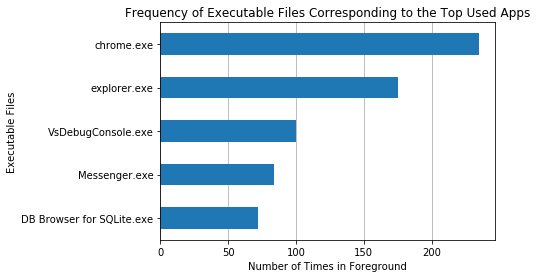

In [13]:
plot = df[df['ID_INPUT'] == 4]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
plot.set_axisbelow(True)
plot.set_xlabel('Number of Times in Foreground')
plot.set_ylabel('Executable Files')
plot.set_title('Frequency of Executable Files Corresponding to the Top Used Apps')
plot.invert_yaxis()
plt.pyplot.grid(axis = 'x')
plt.pyplot.show()

In [14]:
df[df['ID_INPUT'] == 3]['VALUE'].unique()[:5]
#unable to open process is when we use command prompt as an adminstrator

array(['esrv.exe', 'Foreground - Microsoft Visual Studio',
       'How to Configure a C/C++ Project in VS - Google Docs - Google Chrome',
       'Messenger', 'sdk'], dtype=object)

In [15]:
df_string['MEASUREMENT_TIME'].min()

'2023-01-23 17:56:04.607'

In [16]:
df_string['MEASUREMENT_TIME'].max()

'2023-01-23 17:56:44.898'

In [17]:
df[df['ID_INPUT'] == 10]['VALUE'].unique()

array([0], dtype=object)

In [18]:
df.shape[0]/12 # number of unique entries

969.0

In [19]:
tmp = df[df.ID_INPUT == 4]

In [20]:
tmp.VALUE.unique()

array(['VsDebugConsole.exe', 'devenv.exe', 'chrome.exe', 'Messenger.exe',
       'explorer.exe', 'Teams.exe', 'SearchHost.exe',
       'Unable To Open Process', 'python-3.11.1-amd64.exe',
       'ShellExperienceHost.exe', 'Git-2.39.1-64-bit.tmp', 'cmd.exe',
       'CredentialUIBroker.exe', 'ApplicationFrameHost.exe',
       'DB Browser for SQLite.exe', 'Spotify.exe', 'msedge.exe',
       'MoNotificationUx.exe', 'Zoom.exe', 'Docker Desktop.exe',
       'OneDrive.exe', 'winzip64.exe', 'ScreenClippingHost.exe',
       'PickerHost.exe', 'msiexec.exe', 'rundll32.exe', 'conhost.exe',
       'LockApp.exe', 'msteams.exe', 'Acrobat.exe', 'Widgets.exe'],
      dtype=object)

In [21]:
len(tmp.VALUE.unique())

31

In [22]:
tmp.groupby('VALUE').count().sort_values(by="ID_INPUT", ascending=False) # executable can have the extension "tmp"

,MEASUREMENT_TIME,ID_INPUT,PRIVATE_DATA
VALUE,,,
chrome.exe,235,235,235
explorer.exe,175,175,175
VsDebugConsole.exe,100,100,100
Messenger.exe,84,84,84
DB Browser for SQLite.exe,72,72,72
devenv.exe,46,46,46
Unable To Open Process,46,46,46
Teams.exe,43,43,43
ApplicationFrameHost.exe,30,30,30


In [23]:
len(df.PRIVATE_DATA.unique())

1

In [24]:
df = df.assign(date = df["MEASUREMENT_TIME"].astype(str).apply(lambda x: x[:10]))

In [25]:
df.groupby('date').count()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
date,,,,
2023-01-19,3372,3372,3372,3372
2023-01-20,5796,5796,5796,5796
2023-01-21,528,528,528,528
2023-01-22,636,636,636,636
2023-01-23,1296,1296,1296,1296


In [26]:
tab_app = df[df.ID_INPUT == 3]
tab_app.groupby('VALUE').count()

,MEASUREMENT_TIME,ID_INPUT,PRIVATE_DATA,date
VALUE,,,,
.ipynb file is not opening on windows - Google Search - Google Chrome,1,1,1,1
"16 Top-Rated Ski Resorts on the East Coast, 2023 | PlanetWare - Google Chrome",1,1,1,1
A$AP Rocky - Purity (feat. Frank Ocean),1,1,1,1
A.pdf - Google Chrome,1,1,1,1
Administrator: Command Prompt,28,28,28,28
...,...,...,...,...
test-000093.db,1,1,1,1
uninstall apps windows 10 - Google Search - Google Chrome,1,1,1,1
what is a blob in python - Google Search - Google Chrome,4,4,4,4


In [27]:
tab_app['VALUE'][:20]

0                                               esrv.exe
23                  Foreground - Microsoft Visual Studio
33                                              esrv.exe
39     How to Configure a C/C++ Project in VS - Googl...
48                                              esrv.exe
65                                             Messenger
76                                              esrv.exe
85                                                   sdk
105                                             esrv.exe
112    Public -- 2022-2023 (CCG DCA UCSD-HDSI Capston...
123                                             esrv.exe
141    How to Configure a C/C++ Project in VS - Googl...
145                                               Search
167                        Administrator: Command Prompt
177    Installation - pip documentation v22.3.1 - Goo...
191                        Administrator: Command Prompt
195    Installation - pip documentation v22.3.1 - Goo...
215                            